In [35]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import IPython.display as display
import PIL
import PIL.Image
import os
import pathlib
from PIL import Image, ImageFilter

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import classification_report

<h1>  Contrast adjust and Sharpening

<h2>  Train

In [3]:
hel_train_data_path = 'data/mango/train/healthy'
sharp_anth_path = 'data/mango_sharp/train/healthy'

files = os.listdir(hel_train_data_path)

for image in files:
    img = cv2.imread(os.path.join(hel_train_data_path,image))
    
    gaussian_3 = cv2.GaussianBlur(img, (0, 0), 2.0)
    unsharp_image = cv2.addWeighted(img, 3.0, gaussian_3, -1.0, 0)
    
    cv2.imwrite(os.path.join(sharp_anth_path,image),unsharp_image)

In [29]:
anth_train_data_path = 'data/mango/train/anthracnose'
sharp_anth_path = 'data/mango_sharp/train/anthracnose'

files = os.listdir(anth_train_data_path)

for image in files:
    img = cv2.imread(os.path.join(anth_train_data_path,image))
    
    gaussian_3 = cv2.GaussianBlur(img, (0, 0), 2.0)
    unsharp_image = cv2.addWeighted(img, 2.0, gaussian_3, -1.0, 0)
    
    cv2.imwrite(os.path.join(sharp_anth_path,image),unsharp_image)

<h2>  Test

In [30]:
hel_test_data_path = 'data/mango/test/healthy'
sharp_anth_path = 'data/mango_sharp/test/healthy'

files = os.listdir(hel_test_data_path)

for image in files:
    img = cv2.imread(os.path.join(hel_test_data_path,image))
    
    gaussian_3 = cv2.GaussianBlur(img, (0, 0), 2.0)
    unsharp_image = cv2.addWeighted(img, 3.0, gaussian_3, -1.0, 0)
    
    cv2.imwrite(os.path.join(sharp_anth_path,image),unsharp_image)

In [31]:
anth_test_data_path = 'data/mango/test/anthracnose'
sharp_anth_path = 'data/mango_sharp/test/anthracnose'

files = os.listdir(anth_test_data_path)

for image in files:
    img = cv2.imread(os.path.join(anth_test_data_path,image))
    
    gaussian_3 = cv2.GaussianBlur(img, (0, 0), 2.0)
    unsharp_image = cv2.addWeighted(img, 2.0, gaussian_3, -1.0, 0)
    
    cv2.imwrite(os.path.join(sharp_anth_path,image),unsharp_image)

<h1> Load data

In [36]:
from glob import glob

dir1 = 'data/mango_sharp/train'
dir2 = 'data/mango_sharp/test'

data_dir = pathlib.Path(dir1)
test_dir = pathlib.Path(dir2)

print(data_dir)
print(test_dir)

data\mango_sharp\train
data\mango_sharp\test


In [37]:
train_count = len(list(data_dir.glob('*/*.JPG')))
test_count = len(list(test_dir.glob('*/*.JPG')))

print("image amount for train ----> ",train_count)
print("image amount for test  ----> ",test_count)

image amount for train ---->  390
image amount for test  ---->  86


In [38]:
data_test = list(test_dir.glob('*/*'))

In [39]:
batch_size = 32
img_height = 224
img_width = 224

<h1> Data Augmentation

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen_train = ImageDataGenerator(rescale = 1./255,
                                     validation_split=0.2,
                                     rotation_range = 45,
                                     width_shift_range=.15,
                                     height_shift_range =.15,
                                     horizontal_flip=True,
                                     zoom_range=0.6,
                                     
                                     
                                    )

In [41]:
datagen = ImageDataGenerator(width_shift_range=[-30, 30],          
                                height_shift_range=[-30, 30],                              
                                rotation_range=45,
                                zoom_range = [0.6, 0.9] ,
                                 brightness_range=[0.4, 0.9],
                                 horizontal_flip=True,
                                 shear_range=50)

In [42]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                              subset = 'training',  
                                              directory= data_dir,
                                              class_mode="categorical",
                                              shuffle=True,
                                              target_size=(img_height, img_width)
                                              )

Found 313 images belonging to 2 classes.


In [43]:
validation_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                              subset = 'validation',  
                                              directory= data_dir,       
                                              shuffle=True,
                                              target_size=(img_height, img_width)
                                              ) 

Found 77 images belonging to 2 classes.


In [44]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['anthracnose', 'healthy'], dtype='<U11')

In [45]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15,15))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        #plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
    plt.savefig('data_example')

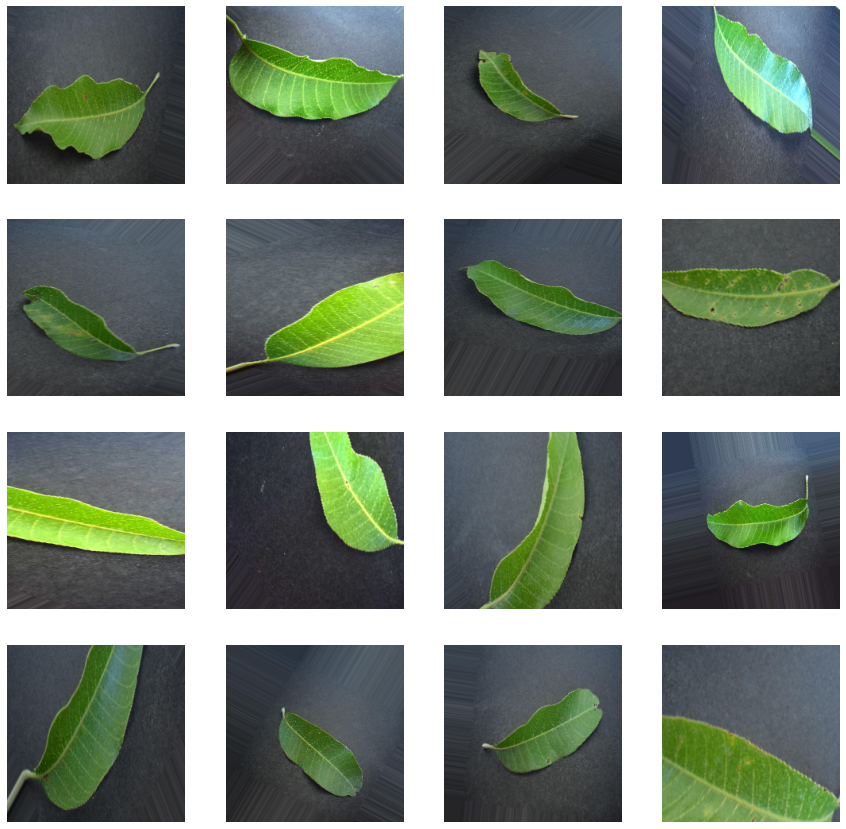

In [46]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

<h1> ********* Convolution part **********"

In [47]:
IMAGE_SIZE = [224, 224]
mobilnet = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in mobilnet.layers:
    layer.trainable = False
folders = glob('data/mango_sharp/train/*')
folders
x = Flatten()(mobilnet.output)
prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=mobilnet.input, outputs=prediction)

In [48]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [49]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [50]:
# model fitting
# take some time bruh!

r = model.fit(
  train_data_gen,
  validation_data=validation_data_gen,
  epochs=10,
  steps_per_epoch=len(train_data_gen),
  validation_steps=len(validation_data_gen)
)

Epoch 1/10
10/10 [==============================] - 166s 16s/step - loss: 0.9491 - accuracy: 0.5815 - val_loss: 0.6172 - val_accuracy: 0.6234
Epoch 2/10
10/10 [==============================] - 142s 15s/step - loss: 0.5078 - accuracy: 0.7412 - val_loss: 0.4370 - val_accuracy: 0.7792
Epoch 3/10
10/10 [==============================] - 137s 14s/step - loss: 0.3459 - accuracy: 0.8562 - val_loss: 0.3658 - val_accuracy: 0.8442
Epoch 4/10
10/10 [==============================] - 145s 15s/step - loss: 0.2833 - accuracy: 0.9042 - val_loss: 0.2683 - val_accuracy: 0.8961
Epoch 5/10
10/10 [==============================] - 138s 14s/step - loss: 0.2246 - accuracy: 0.9361 - val_loss: 0.2715 - val_accuracy: 0.8831
Epoch 6/10
10/10 [==============================] - 138s 14s/step - loss: 0.1983 - accuracy: 0.9329 - val_loss: 0.2511 - val_accuracy: 0.9610
Epoch 7/10
10/10 [==============================] - 151s 15s/step - loss: 0.2220 - accuracy: 0.9169 - val_loss: 0.2367 - val_accuracy: 0.8701
Epoch 

In [51]:
model.save('model_sharp_vgg19.h5')

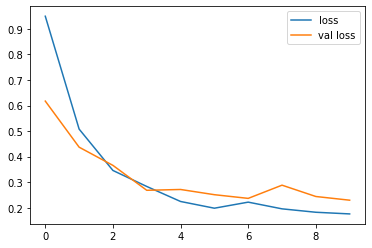

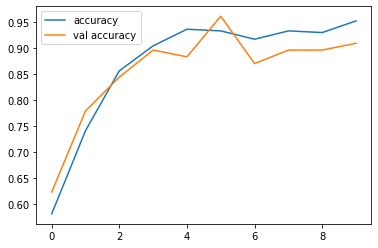

In [54]:
#loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('LossVal_loss_sharp')
plt.show()

#Accuracy
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()

plt.savefig('AccVal_acc_sharp')
plt.show()